# X_ray 이미지로 폐렴 진단하기
* 의학용 이미지는 데이터 수가 적어 딥러닝에 적용하기 어려운 문제가 있다.
* 그래서 데이터를 augmentation하여 데이터의 다양성을 늘려 문제를 해결하는 시도가 많다.
* 하지만 의학용 딥러닝 모델은 사람의 생명을 좌지우지 하는 문제를 다루기 때문에 augmentation 할 때 신중해야 한다.

## Step 1. 실험환경 Set-up
* 패키지(라이브러리)들을 import 하기

In [25]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import cv2
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

* 이미지 크기 확인

In [26]:
img_path = os.getenv('HOME')+'/aiffel/chest_xray/test/NORMAL/IM-0001-0001.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(1317, 1857, 3)


* 앞으로 필요한 변수들을 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj17/aiffel


## Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### Step 2-1. 8:2 분할

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### Step 2-2. 이미지 수 확인

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1064
Pneumonia images count in training set: 3121


* 정상보다 폐렴 이미지 수가 3배 더 많다.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


### Step 2-3. 라벨링 변경
* 정상 NORMAL -> False
* 폐렴 PNEUMONIA -> True

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

### Step 2-4. 이미지 사이즈 축소
* float 타입으로 변경

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### Step 2-5. train, validation 데이터셋 만들기

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

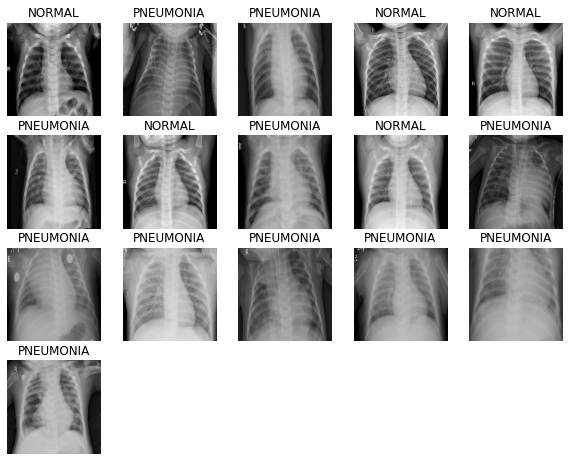

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링
### Step 4-1. Convolution block 만들기

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

### Step 4-2. Dense Block 만들기

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### Step 4-3. Batch Normalization, Dropout적용 CNN 모델 설계 

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


## Step 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

### Step 6-1. 모델 fit

In [21]:

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 25s 96ms/step - loss: 0.3817 - accuracy: 0.8245 - precision: 0.9584 - recall: 0.7993 - val_loss: 0.7274 - val_accuracy: 0.7269 - val_precision: 0.7269 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 22s 85ms/step - loss: 0.2422 - accuracy: 0.9035 - precision: 0.9699 - recall: 0.8987 - val_loss: 1.2212 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 22s 85ms/step - loss: 0.2132 - accuracy: 0.9246 - precision: 0.9759 - recall: 0.9216 - val_loss: 0.2585 - val_accuracy: 0.8923 - val_precision: 0.9985 - val_recall: 0.8541
Epoch 4/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1872 - accuracy: 0.9318 - precision: 0.9810 - recall: 0.9265 - val_loss: 0.1129 - val_accuracy: 0.9519 - val_precision: 0.9481 - val_recall: 0.9881
Epoch 5/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1588 - accuracy: 0

## Step 7. 결과 확인

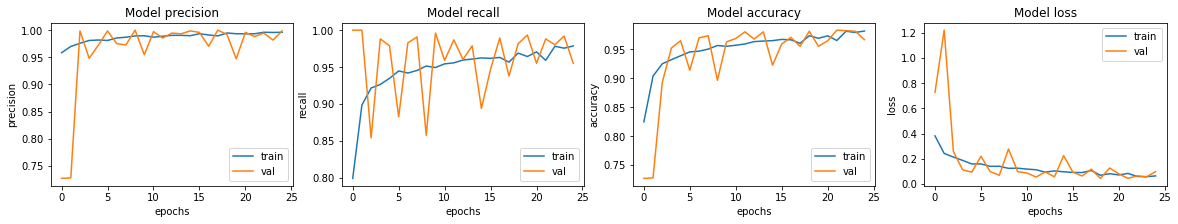

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Step 7-1. 테스트 데이터로 모델 평가

In [23]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 54ms/step - loss: 0.7906 - accuracy: 0.8638 - precision: 0.8366 - recall: 0.9718


## 정리
* 같은 코드인데 어떤때는 accuracy가 74%정도 나오고 재부팅 하고 다시 돌리니 이번엔  accuracy가 86.38% 가 나왔다.
* 같은 코드로 돌릴때마다 accuracy 차이가 커서 왜 그런지 생각을 해봤는데 학습 그래프에서 validation data의 recall 값과  accuracy 값의 지그재그 현상이 심한 것을 보아 test data도 이처럼 지그재그 현상이 커서 accuracy가 왔다갔다 하는게 큰 것 같다.

## Step 8. argumentation 했을 때 결과 확인하기

In [27]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import cv2
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [28]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj17/aiffel


In [29]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [30]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [31]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1096
Pneumonia images count in training set: 3089


In [32]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [33]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [34]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [35]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [36]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### Step 8-1. augmentation 좌우 반전

In [37]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

In [38]:
def prepare_for_training2(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training2(train_ds)
val_ds = prepare_for_training2(val_ds)

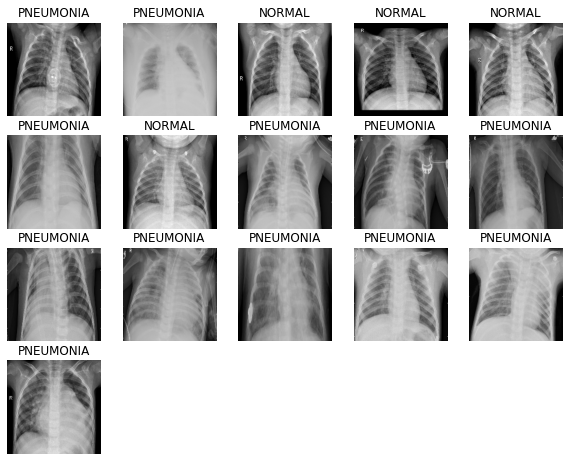

In [39]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

In [40]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.91
Weight for class 1: 0.68


In [41]:
with tf.device('/GPU:0'):
    model_1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [42]:
with tf.device('/GPU:0'):
    history = model_1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 23s 87ms/step - loss: 0.3866 - accuracy: 0.8226 - precision: 0.9617 - recall: 0.7910 - val_loss: 0.7150 - val_accuracy: 0.7567 - val_precision: 0.7567 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 87ms/step - loss: 0.2613 - accuracy: 0.9001 - precision: 0.9661 - recall: 0.8962 - val_loss: 1.0683 - val_accuracy: 0.7596 - val_precision: 0.7596 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 22s 86ms/step - loss: 0.1979 - accuracy: 0.9262 - precision: 0.9806 - recall: 0.9183 - val_loss: 0.6283 - val_accuracy: 0.7615 - val_precision: 0.7608 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1768 - accuracy: 0.9303 - precision: 0.9784 - recall: 0.9259 - val_loss: 0.1176 - val_accuracy: 0.9548 - val_precision: 0.9524 - val_recall: 0.9898
Epoch 5/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1685 - accuracy: 0

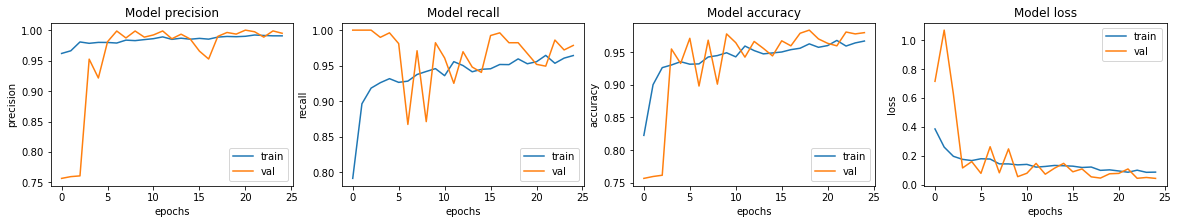

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [45]:
loss, acc, prec, rec = model_1.evaluate(test_ds)

39/39 [==============================] - 2s 57ms/step - loss: 0.7353 - accuracy: 0.8365 - precision: 0.7963 - recall: 0.9923


## 정리2 
* 이미지 좌우반전 argumentation 한 모델은 accuracy가 83.65% 가 나왔다.
* 86.38%에서 83.65%로 줄었고 약 3% 하락한 셈이다.
* 결국 argumentation을 하지 않은 모델이 성능이 더 좋았다.

# 마치며...
* argumentation 좌우반전을 적용하여 정확도를 올리는 방법을 생각해보았다. 일단 지금 적용한 방법은 train dataset에서 원래 이미지를 A라 치고 좌우반전한 이미지를 B라고 치면 B만 사용한다. 이렇게 하는것보단 A와 B 둘다 사용하면 더 좋은 성능을 낼 것 같다. 이미지 좌우반전을 한 후에 plt.savefig() 함수를 이용하여 데이터를 저장하고 다시 불러와서 학습시키면 좋을 것 같다.  